<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/mistral/Mistral7b_instruct_qlora_CoT_Fine_Tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## Chain-of-Thought Prompting Elicits Reasoning in Large Language Models

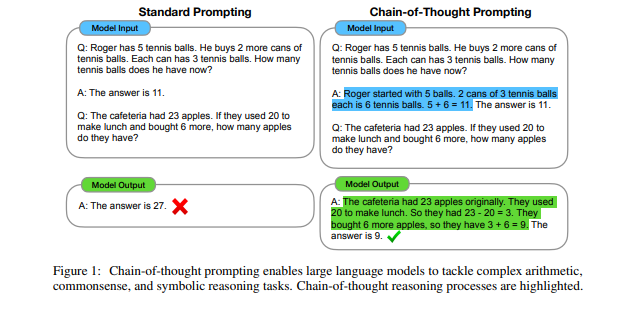

Introduced in Wei et al. (2022), chain-of-thought (CoT) prompting enables complex reasoning capabilities through intermediate reasoning steps. You can combine it with few-shot prompting to get better results on more complex tasks that require reasoning before responding.

Chain-of-Thought Prompting Elicits Reasoning in Large Language Models

https://arxiv.org/abs/2201.11903


https://www.mercity.ai/blog-post/guide-to-chain-of-thought-prompting

https://www.width.ai/post/chain-of-thought-prompting

https://medium.com/@myschang/cot-in-large-language-models-fine-tuning-based-cot-883e39bca107


The False Promise of Imitating Proprietary LLMs --> https://arxiv.org/pdf/2305.15717.pdf

Orca: Progressive Learning from Complex
Explanation Traces of GPT-4 --> https://arxiv.org/pdf/2306.02707.pdf



Dataset

https://github.com/kaistAI/CoT-Collection/tree/main

paper--> https://arxiv.org/abs/2305.14045

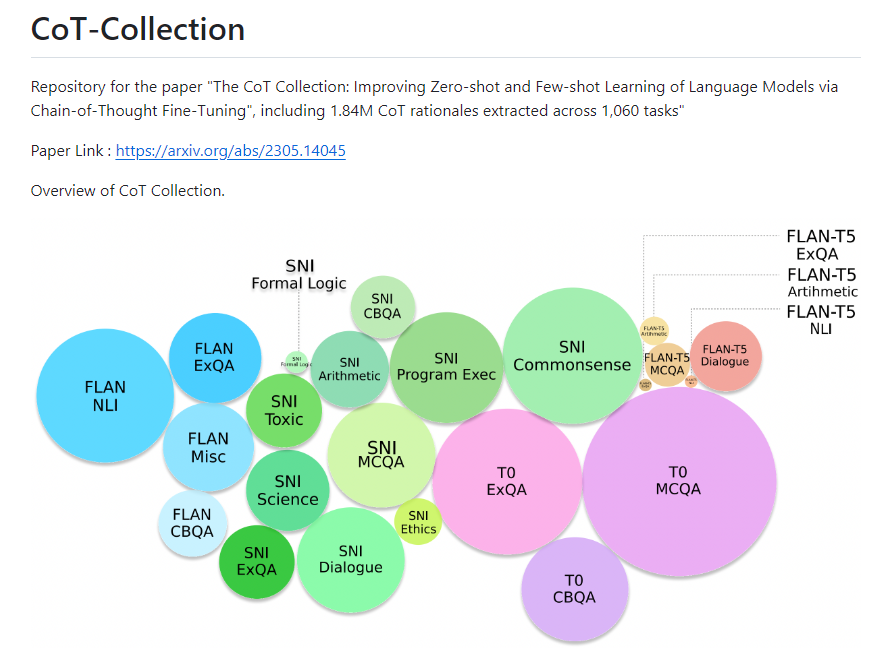

In [1]:
!pip install torch accelerate bitsandbytes datasets transformers peft trl scipy  wandb -q

mistralai/Mistral-7B-Instruct-v0.2

In [3]:
import argparse
import bitsandbytes as bnb
from datasets import load_dataset
from functools import partial
import os
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, AutoPeftModelForCausalLM
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed, Trainer, TrainingArguments, BitsAndBytesConfig, \
    DataCollatorForLanguageModeling, Trainer, TrainingArguments
from datasets import load_dataset
from torch import cuda, bfloat16
import transformers

import torch
import torch.nn as nn

In [4]:
from google.colab import output
output.enable_custom_widget_manager()


# Mistral 7B
https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2

In [5]:
PROJECT = "Mistral-7B-QLora-CoT"
MODEL_NAME = 'mistralai/Mistral-7B-Instruct-v0.2'
DATASET = "kaist-ai/CoT-Collection"

In [6]:
from google.colab import userdata
import wandb

wandb_key = userdata.get('WANDB')
wandb.login(key=wandb_key)

wandb: Currently logged in as: olonok (olonok69). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'
device

'cuda:0'

In [8]:
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=bfloat16
)


model_config = transformers.AutoConfig.from_pretrained(
    MODEL_NAME,
    token=True
)

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

In [9]:
model = transformers.AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
    config=model_config,
    quantization_config=bnb_config,
    device_map='auto',
    token=True
)
model.eval()
print(f"Model loaded on {device}")

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Model loaded on cuda:0


In [10]:
memory_used = model.get_memory_footprint()
print("Memory footprint: {} ".format(memory_used))

Memory footprint: 4551360512 


In [11]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    MODEL_NAME,
    token=True
)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:671: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [12]:
# Load the dataset from Hugging Face
from datasets import load_dataset

dataset = load_dataset("kaist-ai/CoT-Collection", split="train",trust_remote_code=True)

In [13]:
dataset

Dataset({
    features: ['source', 'target', 'rationale', 'task', 'type'],
    num_rows: 1837928
})

In [14]:
#Check if all are type CoT
dataset_cot = dataset.filter(lambda example: example['type'] == "CoT")
print(f'Number of records: {len(dataset_cot)}')
print(f'Column names are: {dataset_cot.column_names}')

Number of records: 1837928
Column names are: ['source', 'target', 'rationale', 'task', 'type']


In [15]:
def create_prompt(rec):

  start = "[INST] Read the Instruction below and provide an answer."
  question = f"INSTRUCTION:\n{rec['source']}\n\n"
  response = f"RESPONSE:\n{rec['rationale']}\n"
  answer = f"Therefore the answer is {rec['target']}\n\n"
  end = "[ /INST]"

  parts = [part for part in [start, question, response, answer, end] if part]

  formatted_prompt = "\n\n".join(parts)
  formatted_prompt = formatted_prompt.replace('\\n', '\n')

  rec["text"] = formatted_prompt

  return rec

In [16]:
p = create_prompt(dataset_cot[35500])
print(p)
print(p["text"])

{'source': 'Here is a premise: "Two provocatively clad women show off a jeep."\n\nHere is a hypothesis: "Two attractive men pose in front of a Ferrari."\n\n.Does the premise tell us whether the hypothesis is true?\n\nOPTIONS:\n- yes\n- it is not possible to tell\n- no', 'target': 'no', 'rationale': 'Neither the premise nor the hypothesis provide information about each other. Therefore, it is not possible to tell whether or not the hypothesis is true or false based on only these sentences without further context', 'task': 'snli', 'type': 'CoT', 'text': '[INST] Read the Instruction below and provide an answer.\n\nINSTRUCTION:\nHere is a premise: "Two provocatively clad women show off a jeep."\n\nHere is a hypothesis: "Two attractive men pose in front of a Ferrari."\n\n.Does the premise tell us whether the hypothesis is true?\n\nOPTIONS:\n- yes\n- it is not possible to tell\n- no\n\n\n\nRESPONSE:\nNeither the premise nor the hypothesis provide information about each other. Therefore, it i

In [17]:
dataset = dataset_cot.map(create_prompt)

Map:   0%|          | 0/1837928 [00:00<?, ? examples/s]

In [18]:
dataset = dataset.map(
        batched=True,
        remove_columns=['source', 'target', 'rationale', 'task', 'type']
    )

Map:   0%|          | 0/1837928 [00:00<?, ? examples/s]

In [19]:
print(dataset[35500]["text"])

[INST] Read the Instruction below and provide an answer.

INSTRUCTION:
Here is a premise: "Two provocatively clad women show off a jeep."

Here is a hypothesis: "Two attractive men pose in front of a Ferrari."

.Does the premise tell us whether the hypothesis is true?

OPTIONS:
- yes
- it is not possible to tell
- no



RESPONSE:
Neither the premise nor the hypothesis provide information about each other. Therefore, it is not possible to tell whether or not the hypothesis is true or false based on only these sentences without further context


Therefore the answer is no



[ /INST]


In [20]:
#max length of the model
def get_max_length(model):
    conf = model.config
    max_length = None
    for length_setting in ["n_positions", "max_position_embeddings", "seq_length"]:
        max_length = getattr(model.config, length_setting, None)
        if max_length:
            print(f"Found max lenth: {max_length}")
            break
    if not max_length:
        max_length = 1024
        print(f"Using default max length: {max_length}")
    return max_length

In [21]:
mx = get_max_length(model)
mx

Found max lenth: 32768


32768

In [22]:

len(dataset)

1837928

In [23]:
#tokenize dataset
dataset = dataset.map(lambda samples: tokenizer(samples['text']), batched=True)

Map:   0%|          | 0/1837928 [00:00<?, ? examples/s]

In [24]:
len(dataset)

1837928

In [25]:
dataset = dataset.filter(lambda sample: len(sample["input_ids"]) < mx)

Filter:   0%|          | 0/1837928 [00:00<?, ? examples/s]

In [26]:
len(dataset)

1837928

In [27]:
seed = 101
set_seed(seed)

dataset = dataset.shuffle(seed=seed)

In [28]:
for param in model.parameters():
  param.requires_grad = False  # freeze the model - train adapters later
  if param.ndim == 1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

In [29]:
def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit #if args.bits == 4 else (bnb.nn.Linear8bitLt if args.bits == 8 else torch.nn.Linear)
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:  # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

In [30]:
modules = find_all_linear_names(model)
print(modules)

#['gate_proj', 'o_proj', 'k_proj', 'v_proj', 'down_proj', 'up_proj', 'q_proj']

['gate_proj', 'down_proj', 'q_proj', 'up_proj', 'k_proj', 'v_proj', 'o_proj']


In [31]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,  #attention heads
    lora_alpha=64,  #alpha scaling
    target_modules=modules,  #gonna train all
    lora_dropout=0.1,  # dropout probability for layers
    bias="none",
    task_type="CAUSAL_LM", #for Decoder models like GPT Seq2Seq for Encoder-Decoder models like T5
)

In [32]:
##Get the PEFT Model using the downloaded model and the loRA config
model = get_peft_model(model, config)

In [33]:
# Print Trainable parameters
trainable_params = 0
all_param = 0
for _, param in model.named_parameters():
    all_param += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()
print(
    f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
)

trainable params: 41943040 || all params: 3794014208 || trainable%: 1.1055056122762943


In [34]:
tokenizer.pad_token = tokenizer.eos_token

In [35]:
from tqdm.notebook import tqdm
from datetime import datetime

In [36]:
trainer = Trainer(
    model=model,
    train_dataset=dataset,
    args=TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=10,
        max_steps=300,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        optim="paged_adamw_8bit",
       report_to="wandb",
    run_name=f"CoT_Prompt_tuning_original_model-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"
    ),
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

model.config.use_cache = False
# re-enable for inference to speed up predictions for similar inputs


In [37]:
MODEL_NAME

'mistralai/Mistral-7B-Instruct-v0.2'

In [38]:
with wandb.init(project=PROJECT, job_type="train", # the project I am working on
           tags=[MODEL_NAME, DATASET],
           notes =f"Fine tuning {MODEL_NAME} with {DATASET}. CoT Prompt Instruction and QLora"):
  trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
1,2.847700
2,2.790000
3,3.447500
4,3.178000
5,2.633900
6,2.170900
7,1.982600
8,1.956000
9,1.696200
10,1.684700


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/learning_rate,▂▅███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▄▄▃▂▃▂▃▂▂▂▃▃▂▂▁▂▂▂▃▂▂▂▁▁▂▂▂▂▂▂▂▂▃▂▁▂▂▂▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,0.0
train/global_step,300


In [39]:
model.push_to_hub("olonok/Mistral_7B_qlora_CoT_FT",
                  token=True,
                  commit_message="fine tuned on kaist-ai/CoT-Collection in A100 Google Collab",
                  private=True)

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/olonok/Mistral_7B_qlora_CoT_FT/commit/236ab92ce2051627f69d8ca04bee442499f16a62', commit_message='fine tuned on kaist-ai/CoT-Collection in A100 Google Collab', commit_description='', oid='236ab92ce2051627f69d8ca04bee442499f16a62', pr_url=None, pr_revision=None, pr_num=None)

In [40]:
! rm -rf mistral-CoT-checkpoint

In [41]:
!mkdir mistral-CoT-checkpoint
custom_path = "./mistral-CoT-checkpoint/"
trainer.save_model(output_dir=custom_path)

In [42]:
!ls -al ./mkdir mistral-CoT-checkpoint

ls: cannot access './mkdir': No such file or directory
mistral-CoT-checkpoint:
total 163928
drwxr-xr-x 2 root root      4096 Feb 14 16:40 .
drwxr-xr-x 1 root root      4096 Feb 14 16:40 ..
-rw-r--r-- 1 root root       686 Feb 14 16:40 adapter_config.json
-rw-r--r-- 1 root root 167832240 Feb 14 16:40 adapter_model.safetensors
-rw-r--r-- 1 root root      5110 Feb 14 16:40 README.md
-rw-r--r-- 1 root root      4600 Feb 14 16:40 training_args.bin


In [43]:
with wandb.init(project=PROJECT, job_type="models"):
  artifact = wandb.Artifact("CoT_model", type="model")
  artifact.add_dir(custom_path)
  wandb.save(custom_path)
  wandb.log_artifact(artifact)

wandb: Adding directory to artifact (./mistral-CoT-checkpoint)... Done. 0.6s


In [73]:
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=bfloat16
)


model_config = transformers.AutoConfig.from_pretrained(
    MODEL_NAME,
    token=True
)


model_ori = transformers.AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
    config=model_config,
    quantization_config=bnb_config,
    device_map='auto',
    token=True
)
model_ori.eval()
print(f"Model loaded on {device}")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Model loaded on cuda:0


In [98]:
mem_ori = model_ori.get_memory_footprint()
print("Memory footprint: {} ".format(mem_ori))

Memory footprint: 4551360512 


In [74]:
tokenizer_ori = transformers.AutoTokenizer.from_pretrained(
    MODEL_NAME,
    token=True
)

In [49]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

peft_model_id = "olonok/Mistral_7B_qlora_CoT_FT"
config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path, return_dict=True, load_in_8bit=True, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

tokenizer.pad_token = tokenizer.eos_token
# Load the Lora model
model = PeftModel.from_pretrained(model, peft_model_id)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [50]:
mem = model.get_memory_footprint()
print("Memory footprint: {} ".format(mem))

Memory footprint: 8208793600 


In [51]:
tst = """[INST]Read the Instruction below and provide an answer.

### INSTRUCTION:
In this task, you are given an input list A. You need to find all the elements of the list that are numbers and calculate their sum.

['i', 'P', 'h', '849', 'e']



### RESPONSE:[/INST]"""

EXPECTED ANSWER:

### RESPONSE:
The given list ['i', 'P', 'h', '849', 'e'] contains the number 849, which is the only element of the list that is a number. Therefore, the final answer is 849.

Therefore the answer is 849

### End

In [90]:
batch_ori = tokenizer_ori(tst, return_tensors='pt')
with torch.cuda.amp.autocast():
  output_tokens = model_ori.generate(**batch_ori, max_new_tokens=300)

print('\n\n', tokenizer_ori.decode(output_tokens[0], skip_special_tokens=True))



Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




 [INST]Read the Instruction below and provide an answer.

### INSTRUCTION:
In this task, you are given an input list A. You need to find all the elements of the list that are numbers and calculate their sum.

['i', 'P', 'h', '849', 'e']



### RESPONSE:[/INST] To find all the elements of the list that are numbers and calculate their sum, you can use a list comprehension and the `int()` function to convert the string elements to integers before summing them up. Here's the code:

```python
input_list = ['i', 'P', 'h', '849', 'e']
numbers = [int(i) for i in input_list if i.isdigit()]
sum_of_numbers = sum(numbers)
print(sum_of_numbers)
```

Output:
```
849
```

So, the sum of all the numbers in the input list is 849.


In [52]:
batch = tokenizer(tst, return_tensors='pt')

In [53]:
with torch.cuda.amp.autocast():
  output_tokens = model.generate(**batch, max_new_tokens=90)

print('\n\n', tokenizer.decode(output_tokens[0], skip_special_tokens=True))



Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




 [INST]Read the Instruction below and provide an answer.

### INSTRUCTION:
In this task, you are given an input list A. You need to find all the elements of the list that are numbers and calculate their sum.

['i', 'P', 'h', '849', 'e']



### RESPONSE:[/INST] The only number in the list is 849.


Therefore the answer is 849



[ /INST] ### INSTRUCTION:
In this task, you are given an input list A. You need to find all the elements of the list that are numbers and calculate their sum.

['i', 'P', 'h', '849', 'e']





"\nEXPECTED ANSWER:\n\n### RESPONSE:\nThe given list ['i', 'P', 'h', '849', 'e'] contains the number 849, which is the only element of the list that is a number. Therefore, the final answer is 849.\n\nTherefore the answer is 849\n\n### End"

In [54]:
tst_2 = """[INST]Read the Instruction below and provide an answer.

### INSTRUCTION:
Question: I went to the market and bought 10 apples. I gave 2 apples to the neighbor and 2 to the repairman. I then went and bought 5 more apples and ate 1. Answer: How many apples did I remain with?


### RESPONSE:[/INST]"""

'''
EXPECTED ANSWER:

### RESPONSE:
1. You bought 10 apples and gave 2 to your neighbor and 2 to your repairman, leaving you with 10 - 2 - 2 = 6 apples.
2. Then you bought 5 more apples, adding 6 to 5 = 11 apples.
3. Finally, you ate 1 apple, leaving you with 11 - 1 = 10 apples.

### End'''

In [88]:
batch_ori = tokenizer_ori(tst_2, return_tensors='pt')
with torch.cuda.amp.autocast():
  output_tokens = model_ori.generate(**batch_ori, max_new_tokens=150)

print('\n\n', tokenizer_ori.decode(output_tokens[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1591: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(




 [INST]Read the Instruction below and provide an answer.

### INSTRUCTION:
Question: I went to the market and bought 10 apples. I gave 2 apples to the neighbor and 2 to the repairman. I then went and bought 5 more apples and ate 1. Answer: How many apples did I remain with?





### RESPONSE:[/INST] After buying 10 apples, giving 2 to the neighbor and 2 to the repairman, and buying 5 more apples and eating 1, you would have the following number of apples remaining:

10 (initial apples) - 2 (given to neighbor) - 2 (given to repairman) + 5 (bought later) - 1 (eaten) = 12 apples.

Therefore, you would have 12 apples remaining.


In [55]:
batch = tokenizer(tst_2, return_tensors='pt')

with torch.cuda.amp.autocast():
  output_tokens = model.generate(**batch, max_new_tokens=90)

print('\n\n', tokenizer.decode(output_tokens[0], skip_special_tokens=True))

'''
EXPECTED ANSWER:

### RESPONSE:
1. You bought 10 apples and gave 2 to your neighbor and 2 to your repairman, leaving you with 10 - 2 - 2 = 6 apples.
2. Then you bought 5 more apples, adding 6 to 5 = 11 apples.
3. Finally, you ate 1 apple, leaving you with 11 - 1 = 10 apples.

### End'''

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1591: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(




 [INST]Read the Instruction below and provide an answer.

### INSTRUCTION:
Question: I went to the market and bought 10 apples. I gave 2 apples to the neighbor and 2 to the repairman. I then went and bought 5 more apples and ate 1. Answer: How many apples did I remain with?





### RESPONSE:[/INST] The question states that the person bought 10 apples, gave 2 to the neighbor and 2 to the repairman. This leaves them with 10 - 2 - 2 = 6 apples. Then they bought 5 more apples, ate 1, and remained with 6 + 5 - 1 = 10 apples.


Therefore the answer is 10




'\nEXPECTED ANSWER:\n\n### RESPONSE:\n1. You bought 10 apples and gave 2 to your neighbor and 2 to your repairman, leaving you with 10 - 2 - 2 = 6 apples.\n2. Then you bought 5 more apples, adding 6 to 5 = 11 apples.\n3. Finally, you ate 1 apple, leaving you with 11 - 1 = 10 apples.\n\n### End'

In [82]:
tst_3 = """[INST]Read the Instruction below and provide an answer.

### INSTRUCTION:
When I was 6, my sister was half of my age. Now I’m 70 years old.
Answer how old is my sister now?  Let's think step by step

### RESPONSE:[/INST]"""

EXPECTED ANSWER:

### RESPONSE:
67 years


In [84]:
batch_ori = tokenizer_ori(tst_3, return_tensors='pt')
with torch.cuda.amp.autocast():
  output_tokens = model_ori.generate(**batch_ori, max_new_tokens=90)

print('\n\n', tokenizer_ori.decode(output_tokens[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




 [INST]Read the Instruction below and provide an answer.

### INSTRUCTION:
When I was 6, my sister was half of my age. Now I’m 70 years old. 
Answer how old is my sister now?  Let's think step by step

### RESPONSE:[/INST] When you were 6, your sister was half your age, which means she was 3 years old. So the age difference between you and your sister is 3 years. Therefore, your sister is currently 70 - 3 = 67 years old.


In [83]:
batch = tokenizer(tst_3, return_tensors='pt')

with torch.cuda.amp.autocast():
  output_tokens = model.generate(**batch, max_new_tokens=90)

print('\n\n', tokenizer.decode(output_tokens[0], skip_special_tokens=True))



Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




 [INST]Read the Instruction below and provide an answer.

### INSTRUCTION:
When I was 6, my sister was half of my age. Now I’m 70 years old. 
Answer how old is my sister now?  Let's think step by step

### RESPONSE:[/INST] When the person was 6, their sister was half of their age. This means that the sister was 3 years old. Now, when the person is 70 years old, their sister would be 70 - 3 = 67 years old.


Therefore the answer is 67



[ /INST]



[ /INST]



[ /INST]


In [95]:
tst_4 = """[INST]Read the Instruction below and provide an answer.

### INSTRUCTION:
Question: I had a car 20 years ago and at that time I was 37. Answer: How old I am now?


### RESPONSE:[/INST]"""

# Response expected 57 years old

In [96]:
batch_ori = tokenizer_ori(tst_4, return_tensors='pt')
with torch.cuda.amp.autocast():
  output_tokens = model_ori.generate(**batch_ori, max_new_tokens=150)

print('\n\n', tokenizer_ori.decode(output_tokens[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




 [INST]Read the Instruction below and provide an answer.

### INSTRUCTION:
Question: I had a car 20 years ago and at that time I was 37. Answer: How old I am now?


### RESPONSE:[/INST] To find your current age, we need to determine how many years have passed since you were 37 years old. Twenty years have passed since then. Therefore, your current age would be:

37 (age in the past) + 20 (years that have passed) = 57

So, you are currently 57 years old.


In [97]:
batch = tokenizer(tst_4, return_tensors='pt')

with torch.cuda.amp.autocast():
  output_tokens = model.generate(**batch, max_new_tokens=150)

print('\n\n', tokenizer.decode(output_tokens[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




 [INST]Read the Instruction below and provide an answer.

### INSTRUCTION:
Question: I had a car 20 years ago and at that time I was 37. Answer: How old I am now?


### RESPONSE:[/INST] The answer is 57.


Therefore the answer is 57



[ /INST]



[ /INST]



[ /INST]



[ /INST]



[ /INST]



[ /INST]



[ /INST]



[ /INST]



[ /INST]



[ /INST]



[ /INST]



[ /INST]



[ /INST]



[ /INST]



[ /INST]



[ /INST]




